In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

In [2]:
from google.colab import drive #Lo ligamos a nuestra memoria en drive
drive.mount('/content/drive',timeout_ms=600000)

Mounted at /content/drive


In [3]:
#Así se guardan
folder = '/content/drive/MyDrive/AI/data/datos_RETO/'
images_train = np.load(folder + 'datos_RETOimages_train.npy')
masks_train = np.load(folder + 'datos_RETOmasks_train.npy')
images_val = np.load(folder + 'datos_RETOimages_val.npy')
masks_val = np.load(folder + 'datos_RETOmasks_val.npy')
images_test = np.load(folder + 'datos_RETOimages_test.npy')
masks_test = np.load(folder + 'datos_RETOmasks_test.npy')

In [4]:
# Establece un umbral para la binarización de las mascaras
threshold = 0.5

masks_train = np.where(masks_train >= threshold, 1, 0)
masks_val = np.where(masks_val >= threshold, 1, 0)
masks_test = np.where(masks_test >= threshold, 1, 0)

In [5]:
import tensorflow as tf


def dice_coefficient(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float32)  # Convertir y_true a float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection) / (union + 1e-5)
    return dice

In [6]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

model = Sequential()

# Base convolucional
model.add(layers.Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(112, 112, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Regularización L2
model.add(layers.Flatten())
model.add(Dense(112, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dense((112*112), activation='sigmoid'))
model.add(Dropout(0.5))
model.add(layers.Reshape((112, 112,1)))

checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss

keras.utils.get_custom_objects()['dice_coefficient'] = dice_coefficient

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 32)        0         
 D)                                                              
                                                        

In [8]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss=[dice_coef_loss],  # Utiliza binary_crossentropy para máscaras binarias
              metrics=[dice_coefficient])

# Entrenar el modelo
history = model.fit(images_train, masks_train, epochs=20, batch_size=32, validation_data=(images_val, masks_val),callbacks=[checkpoint])

# Evaluar el modelo en datos de prueba
test_loss, test_dice_score = model.evaluate(images_test, masks_test)
print(f'Loss en datos de prueba: {test_loss}')
print(f'DICE SCORE en datos de prueba: {test_dice_score}')

Epoch 1/20
467/467 [==============================] - ETA: 0s - loss: -0.5892 - dice_coefficient: 0.6052
Epoch 1: val_dice_coefficient improved from -inf to 0.83178, saving model to mejor_modelo.h5
467/467 [==============================] - 50s 70ms/step - loss: -0.5892 - dice_coefficient: 0.6052 - val_loss: -0.8154 - val_dice_coefficient: 0.8318
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


466/467 [============================>.] - ETA: 0s - loss: -0.8409 - dice_coefficient: 0.8566
Epoch 2: val_dice_coefficient improved from 0.83178 to 0.86495, saving model to mejor_modelo.h5
467/467 [==============================] - 31s 67ms/step - loss: -0.8409 - dice_coefficient: 0.8566 - val_loss: -0.8501 - val_dice_coefficient: 0.8649
Epoch 3/20
466/467 [============================>.] - ETA: 0s - loss: -0.8623 - dice_coefficient: 0.8765
Epoch 3: val_dice_coefficient improved from 0.86495 to 0.88311, saving model to mejor_modelo.h5
467/467 [==============================] - 31s 67ms/step - loss: -0.8622 - dice_coefficient: 0.8764 - val_loss: -0.8677 - val_dice_coefficient: 0.8831
Epoch 4/20
466/467 [============================>.] - ETA: 0s - loss: -0.8703 - dice_coefficient: 0.8854
Epoch 4: val_dice_coefficient improved from 0.88311 to 0.88976, saving model to mejor_modelo.h5
467/467 [==============================] - 32s 69ms/step - loss: -0.8703 - dice_coefficient: 0.8854 - val_

In [9]:
model = keras.models.load_model('mejor_modelo.h5')

In [41]:
index = 33
image_test = images_test[index]

1/1 [==============================] - 0s 47ms/step
Imagen Original


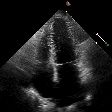

Mascara Predicha


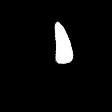

Mascara Sobrepuesta


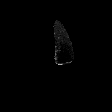

Máscara Original


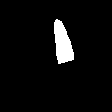

In [42]:
predicted_mask = model.predict(np.expand_dims(image_test, axis=0))[0]

from google.colab.patches import cv2_imshow
import cv2

# Escala la máscara de vuelta a [0, 255] y conviértela en una imagen en escala de grises
masks_test_original_gray = (masks_test[index] * 255).astype(np.uint8)
predicted_mask_gray = (predicted_mask * 255).astype(np.uint8)

# Asegura que la máscara generada tenga las mismas dimensiones que la imagen original
predicted_mask_resized = cv2.resize(predicted_mask_gray, (image_test.shape[1], image_test.shape[0]))
masks_test_original_resized = cv2.resize(masks_test_original_gray, (image_test.shape[1], image_test.shape[0]))

# Aplica la máscara en blanco y negro a la imagen original
overlaid_image = cv2.bitwise_and(image_test, image_test, mask=predicted_mask_resized)

# Muestra la imagen original, la máscara en blanco y negro y la imagen superpuesta
print("Imagen Original")
cv2_imshow(image_test)
print("Mascara Predicha")
cv2_imshow(predicted_mask_resized)
print("Mascara Sobrepuesta")
cv2_imshow(overlaid_image)
print("Máscara Original")
cv2_imshow(masks_test_original_resized)

In [12]:
import cv2
import os
import numpy as np

# Carpeta que contiene los videos
folder = '/content/drive/MyDrive/AI/data/Apical/'

# Carpeta de salida para las imágenes
output_folder = '/content/drive/MyDrive/AI/data/Apical_frames/'

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Lista para almacenar todas las imágenes
all_frames = []

# Recorrer todos los archivos en la carpeta
for filename in os.listdir(folder):
    if filename.endswith(".avi"):
        video_path = os.path.join(folder, filename)

        # Abrir el video
        cap = cv2.VideoCapture(video_path)

        # Obtener la información del video
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Recorrer todos los frames
        for frame_number in range(total_frames):
            # Leer el frame
            ret, frame = cap.read()
            if not ret:
                break

            # Almacenar el frame en la lista
            all_frames.append(frame)

            # Guardar el frame como una imagen
            output_path = os.path.join(output_folder, f"{filename}_{frame_number:04d}.png")
            cv2.imwrite(output_path, frame)

        # Cerrar el video
        cap.release()

# Convertir la lista de frames a un array NumPy
frames_array = np.array(all_frames)

# Verificar la forma del array
print("Shape of frames array:", frames_array.shape)


Shape of frames array: (583, 564, 800, 3)


In [17]:
image_test.shape

(112, 112, 3)

In [13]:
video_path

'/content/drive/MyDrive/AI/data/Apical/00026.avi'

In [24]:
index = 3
image_test2 = frames_array[index]

In [25]:
print("Dimensiones de la imagen de prueba:", image_test2.shape)

Dimensiones de la imagen de prueba: (564, 800, 3)


In [26]:
image_test2 = cv2.resize(image_test2, (112, 112))

# Ahora, 'image_resized' tiene forma (112, 112, 3)
print("Dimensiones de la imagen redimensionada:", image_test2.shape)

Dimensiones de la imagen redimensionada: (112, 112, 3)


1/1 [==============================] - 0s 31ms/step
Imagen Original


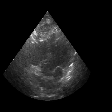

Mascara Predicha


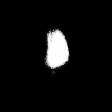

Mascara Sobrepuesta


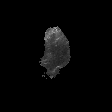

In [40]:
index = 564
image_test2 = frames_array[index]
image_test2 = cv2.resize(image_test2, (112, 112))

predicted_mask = model.predict(np.expand_dims(image_test2, axis=0))[0]

from google.colab.patches import cv2_imshow
import cv2

# Escala la máscara de vuelta a [0, 255] y conviértela en una imagen en escala de grises

predicted_mask_gray = (predicted_mask * 255).astype(np.uint8)

# Asegura que la máscara generada tenga las mismas dimensiones que la imagen original
predicted_mask_resized = cv2.resize(predicted_mask_gray, (image_test2.shape[1], image_test2.shape[0]))

# Aplica la máscara en blanco y negro a la imagen original
overlaid_image = cv2.bitwise_and(image_test2, image_test2, mask=predicted_mask_resized)

# Muestra la imagen original, la máscara en blanco y negro y la imagen superpuesta
print("Imagen Original")
cv2_imshow(image_test2)
print("Mascara Predicha")
cv2_imshow(predicted_mask_resized)
print("Mascara Sobrepuesta")
cv2_imshow(overlaid_image)

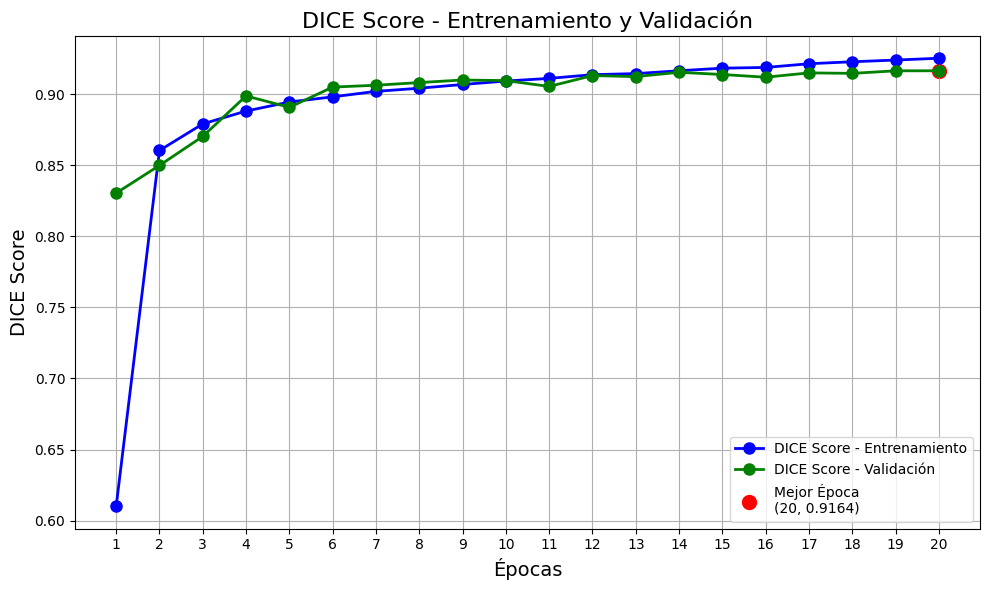

In [44]:
import matplotlib.pyplot as plt

# Extraer las métricas del historial
dice_coef = history.history['dice_coefficient']
val_dice_coef = history.history['val_dice_coefficient']

# Crear un rango de épocas para el eje x
epochs = range(1, len(dice_coef) + 1)

# Graficar el coeficiente DICE para entrenamiento y validación
plt.figure(figsize=(10, 6))

# Lineas para entrenamiento y validación
plt.plot(epochs, dice_coef, 'bo-', label='DICE Score - Entrenamiento', linewidth=2, markersize=8)
plt.plot(epochs, val_dice_coef, 'go-', label='DICE Score - Validación', linewidth=2, markersize=8)

# Puntos de interés
best_epoch = np.argmax(val_dice_coef) + 1
best_val_dice_coef = max(val_dice_coef)
plt.scatter(best_epoch, best_val_dice_coef, color='red', marker='o', s=100, label=f'Mejor Época\n({best_epoch}, {best_val_dice_coef:.4f})')

# Detalles de la gráfica
plt.title('DICE Score - Entrenamiento y Validación', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('DICE Score', fontsize=14)
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar la gráfica
plt.show()



In [13]:
import cv2
import os
import numpy as np

# Carpeta que contiene los videos
folder = '/content/drive/MyDrive/AI/data/Apical/'

# Carpeta de salida para las imágenes
output_folder = '/content/drive/MyDrive/AI/data/Apical_frames/'

# Carpeta de salida para los frames procesados
processed_folder = '/content/drive/MyDrive/AI/data/Apical_processed_frames/'

# Video específico a procesar
video_name = '00023.avi'
video_path = os.path.join(folder, video_name)

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)
os.makedirs(processed_folder, exist_ok=True)

# Lista para almacenar todos los frames
all_frames = []

# Lista para almacenar los frames procesados
processed_frames = []

# Abrir el video
cap = cv2.VideoCapture(video_path)

# Obtener la información del video
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Recorrer todos los frames
for frame_number in range(total_frames):
    # Leer el frame
    ret, frame = cap.read()
    if not ret:
        break

    # Almacenar el frame en la lista
    all_frames.append(frame)

    # Guardar el frame como una imagen
    output_path = os.path.join(output_folder, f"{video_name}_{frame_number:04d}.png")
    cv2.imwrite(output_path, frame)

    frame = cv2.resize(frame, (112, 112))

    # Aplicar el modelo al frame
    predicted_mask = model.predict(np.expand_dims(frame, axis=0))[0]

    # Escala la máscara de vuelta a [0, 255] y conviértela en una imagen en escala de grises
    predicted_mask_gray = (predicted_mask * 255).astype(np.uint8)

    # Asegura que la máscara generada tenga las mismas dimensiones que la imagen original
    predicted_mask_resized = cv2.resize(predicted_mask_gray, (frame.shape[1], frame.shape[0]))

    # Aplica la máscara en blanco y negro al frame original
    overlaid_frame = cv2.bitwise_and(frame, frame, mask=predicted_mask_resized)

    # Almacena el frame procesado en la lista
    processed_frames.append(overlaid_frame)

    # Guarda el frame procesado como una imagen
    processed_output_path = os.path.join(processed_folder, f"{video_name}_{frame_number:04d}.png")
    cv2.imwrite(processed_output_path, overlaid_frame)

# Cerrar el video
cap.release()

# Convertir la lista de frames a un array NumPy
frames_array = np.array(all_frames)

# Verificar la forma del array
print("Shape of frames array:", frames_array.shape)

# Guardar los frames procesados en un nuevo video AVI
output_video_path = '/content/drive/MyDrive/AI/data/Apical_processed_video23.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame.shape[1], frame.shape[0]))

for processed_frame in processed_frames:
    output_video.write(processed_frame)

output_video.release()
print("Video procesado guardado en:", output_video_path)


1/1 [==============================] - 0s 22ms/step
Shape of frames array: (49, 564, 800, 3)
Video procesado guardado en: /content/drive/MyDrive/AI/data/Apical_processed_video23.avi


In [14]:
import cv2
import os

# Carpeta que contiene los videos
folder = '/content/drive/MyDrive/AI/data/Apical/'

# Carpeta de salida para los frames redimensionados
resized_folder = '/content/drive/MyDrive/AI/data/Apical_resized_frames/'

# Video específico a procesar
video_name = '00023.avi'
video_path = os.path.join(folder, video_name)

# Crear la carpeta de salida si no existe
os.makedirs(resized_folder, exist_ok=True)

# Abrir el video
cap = cv2.VideoCapture(video_path)

# Obtener la información del video
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Configurar el tamaño deseado
target_size = (112, 112)

# Configurar el VideoWriter para el video redimensionado
output_video_path = os.path.join(resized_folder, f"{video_name}_resized.avi")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, fourcc, fps, target_size)

# Recorrer todos los frames
for frame_number in range(total_frames):
    # Leer el frame
    ret, frame = cap.read()
    if not ret:
        break

    # Redimensionar el frame al tamaño deseado
    resized_frame = cv2.resize(frame, target_size)

    # Guarda el frame redimensionado en el VideoWriter
    output_video.write(resized_frame)

# Cerrar el video y el VideoWriter
cap.release()
output_video.release()

print("Video redimensionado guardado en:", output_video_path)

Video redimensionado guardado en: /content/drive/MyDrive/AI/data/Apical_resized_frames/00023.avi_resized.avi
